In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
train = tf.keras.utils.image_dataset_from_directory(
    "training-data",                             
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

validation = tf.keras.utils.image_dataset_from_directory(
    "training-data",                             
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

Found 606 files belonging to 3 classes.
Using 485 files for training.
Found 606 files belonging to 3 classes.
Using 121 files for validation.


In [4]:
class_names = train.class_names

2023-10-26 14:37:58.018362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


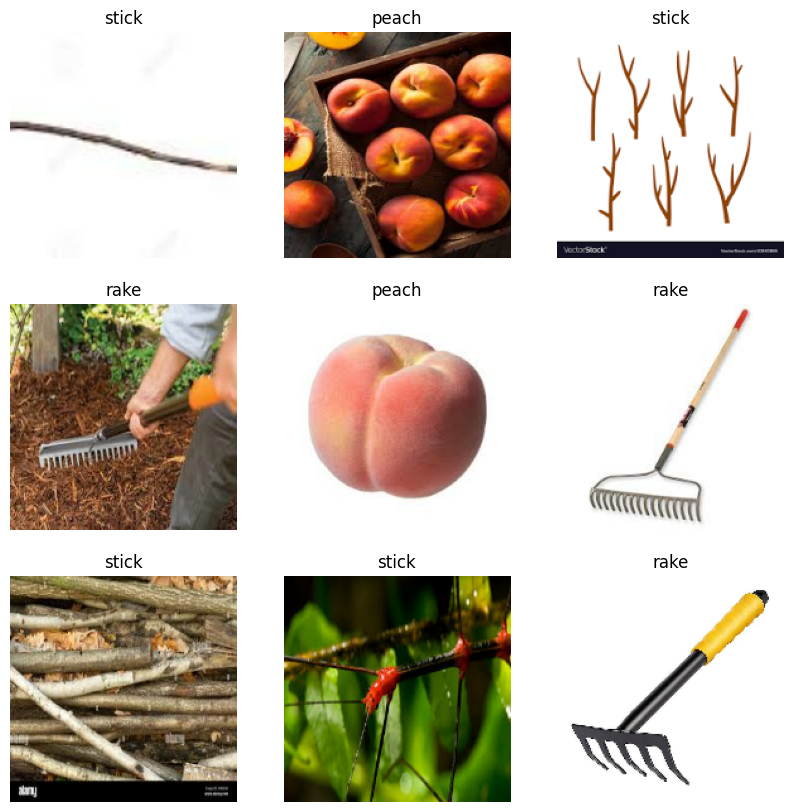

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


2023-10-26 14:38:05.261884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

normalized = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-10-26 14:38:14.859033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


0.006678922 1.0


In [11]:
num_classes = len(class_names)
img_height = img_width = 180

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs=10
history = model.fit(
  train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/10
16/16 [==============================] - 2s 141ms/step - loss: 1.0638e-04 - accuracy: 1.0000 - val_loss: 0.6024 - val_accuracy: 0.9008
Epoch 2/10
16/16 [==============================] - 2s 132ms/step - loss: 1.0167e-04 - accuracy: 1.0000 - val_loss: 0.6063 - val_accuracy: 0.9008
Epoch 3/10
16/16 [==============================] - 2s 132ms/step - loss: 9.5635e-05 - accuracy: 1.0000 - val_loss: 0.6124 - val_accuracy: 0.9008
Epoch 4/10
16/16 [==============================] - 2s 137ms/step - loss: 8.9643e-05 - accuracy: 1.0000 - val_loss: 0.6191 - val_accuracy: 0.9008
Epoch 5/10
16/16 [==============================] - 2s 134ms/step - loss: 8.8096e-05 - accuracy: 1.0000 - val_loss: 0.6218 - val_accuracy: 0.9008
Epoch 6/10
16/16 [==============================] - 2s 136ms/step - loss: 7.8738e-05 - accuracy: 1.0000 - val_loss: 0.6291 - val_accuracy: 0.9008
Epoch 7/10
16/16 [==============================] - 2s 132ms/step - loss: 7.7458e-05 - accuracy: 1.0000 - val_loss: 0.6302 -

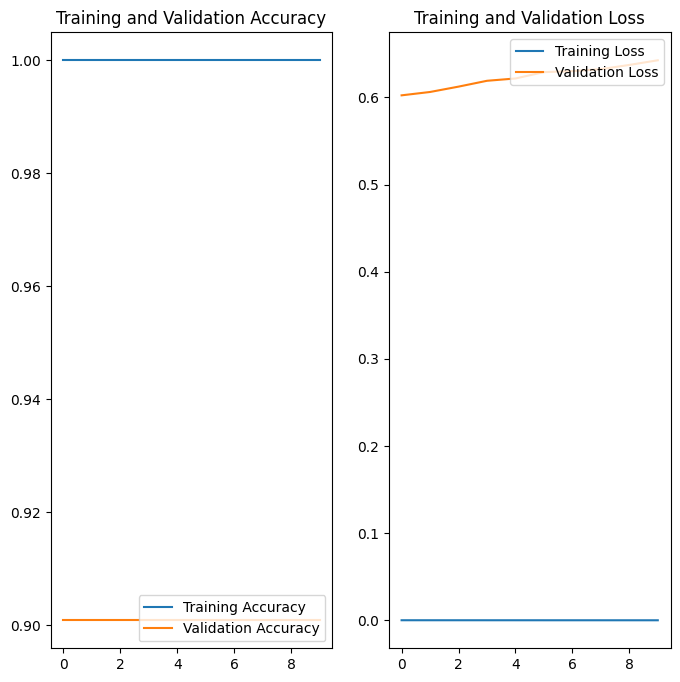

In [22]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
img = tf.keras.utils.load_img("20101123131216-1_0.jpg", target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to peach with a 100.00 percent confidence.


In [33]:
model.save('model.keras')

In [35]:
import tensorflowjs as tfjs

In [37]:
tfjs.converters.save_keras_model(model, "/Users/vincentzhao/Documents/mk-scavenger-hunt/src/model")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
